In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from model import ConvModel, siamese, contrastive_loss_with_margin
from tqdm.notebook import tqdm

%matplotlib inline


In [2]:
from PIL import Image
import os
from pathlib import Path

IMAGE_DIR = Path("data")

def load_images():
    images = []
    names = []
    for d in tqdm(os.listdir(IMAGE_DIR), desc="Progress"):
        for im in os.listdir(IMAGE_DIR/d):
            with Image.open(IMAGE_DIR/d/im) as image:
                image = image.resize((50, 50))
                images.append(list(np.array(image) / 255.))
                names.append(d)

    return images, names

images, names = load_images()

In [3]:
from sklearn.model_selection import train_test_split

images = np.array(images)
names = np.array(names)
X_train, X_test, y_train, y_test = train_test_split(images, names, test_size=.2)

del images
del names

In [4]:
def create_pairs(images, names):
    
    pairs = []
    labels = []
    
    uniq_faces = np.unique(names)
    idx = {i: np.where(names == i)[0] for i in uniq_faces}
    
    for i in range(len(images)):
        im1 = images[i]
        name = names[i]
        
        # Positive pair
        j = np.random.choice(idx[name])
        im2 = images[j]
        
        pairs.append([im1, im2])
        labels.append(1)
        
        # Negative pair
        k = np.where(names != name)[0]
        im3 = images[np.random.choice(k)]
        
        pairs.append([im1, im3])
        labels.append(0)
        
    labels = np.array(labels)
    labels = labels.astype("float32")
        
    return np.array(pairs), np.array(labels)
        

train_pairs, train_labels = create_pairs(X_train, y_train)
test_pairs, test_labels = create_pairs(X_test, y_test)

del X_train, y_train, X_test, y_test

Different person


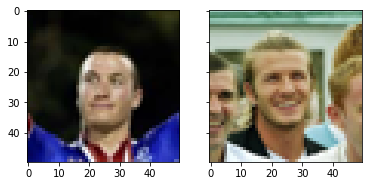

In [5]:
idx = np.random.randint(0, len(train_pairs))
example_pair = train_pairs[idx]
example_label = "Same person" if train_labels[idx] == 1 else "Different person"

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].imshow(example_pair[0])
axs[1].imshow(example_pair[1])
print(example_label)

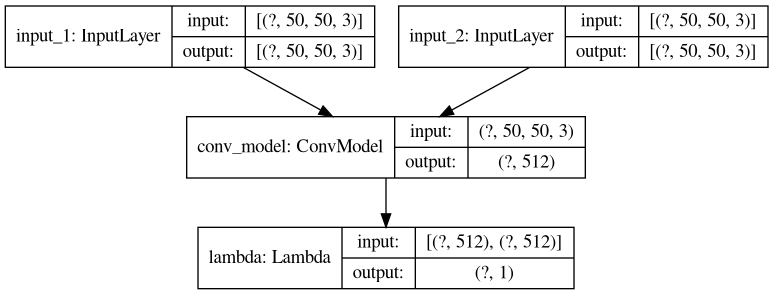

In [6]:
model = siamese(input_shape=(25, 25, 3))
model.compile(optimizer="adam", loss=contrastive_loss_with_margin(margin=1), metrics=["accuracy"])
plot_model(model, show_shapes=True)

In [7]:
model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels, epochs=10, batch_size=200)

Epoch 1/10
106/106 [==============================] - 27s 251ms/step - loss: 137.4261 - accuracy: 0.5000
Epoch 2/10
106/106 [==============================] - 25s 238ms/step - loss: 53.0770 - accuracy: 0.4957
Epoch 3/10
106/106 [==============================] - 25s 239ms/step - loss: 22.6779 - accuracy: 0.4590
Epoch 4/10
106/106 [==============================] - 25s 239ms/step - loss: 9.8275 - accuracy: 0.3742
Epoch 5/10
106/106 [==============================] - 25s 240ms/step - loss: 6.4263 - accuracy: 0.3312
Epoch 6/10
106/106 [==============================] - 25s 240ms/step - loss: 3.6050 - accuracy: 0.2974
Epoch 7/10
106/106 [==============================] - 25s 240ms/step - loss: 2.4994 - accuracy: 0.2888
Epoch 8/10
106/106 [==============================] - 25s 240ms/step - loss: 1.9858 - accuracy: 0.2892
Epoch 9/10
106/106 [==============================] - 25s 240ms/step - loss: 3.0088 - accuracy: 0.2930
Epoch 10/10
106/106 [==============================] - 25s 240ms/step

In [8]:
#model.save_weights("siamese.h5")
#model.load_weights("siamese.h5")
res, acc = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]])
print(acc)

166/166 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0


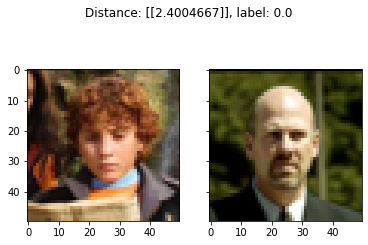

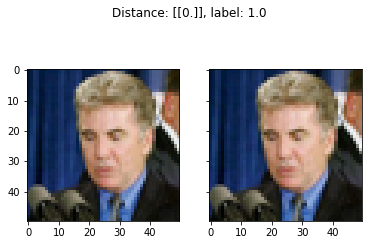

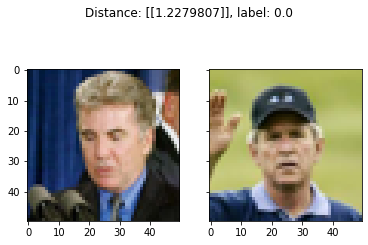

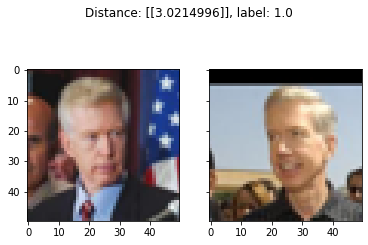

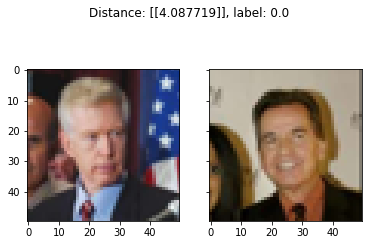

In [24]:
idx = np.random.randint(len(test_pairs))
example_pairs = test_pairs[idx:idx+5]
for i, example in enumerate(example_pairs):
    fig, axs = plt.subplots(1, 2, sharey=True)
    axs[0].imshow(example[0])
    axs[1].imshow(example[1])
    distance = model.predict([example[0][np.newaxis, :], example[1][np.newaxis]])
    fig.suptitle(f"Distance: {distance}, label: {test_labels[idx + i]}")